# On Deep Learning-Based Channel Decoding

If you want to cite this notebook, please use the following bibtext entry:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

Running this example requires Keras installed with the Theano backend. For GPU support nvidia-docker is required. A Dockerfile is provided to employ this setup quickly.

Our simulation setup was inspired by material from http://radioml.org.


In [1]:
from os import environ
environ['KERAS_BACKEND']='tensorflow'

In [2]:
from datetime import datetime
from keras import backend as K
from keras.layers.core import Dense, Lambda
from keras.models import Sequential
import base64
import json
import keras as k_tmp
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow as tf_tmp
import timeit
%matplotlib inline
print(K.backend())

Using TensorFlow backend.


tensorflow


In [3]:
import tensorflow as tf
print(tf.test.is_gpu_available(cuda_only=True))
from tensorflow.python.client import device_lib
print(str(device_lib.list_local_devices()))

True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2159108570429568566
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3173977294
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16812210731751052571
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


# Parameters

In [4]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

#nb_epochs = [2**x for x in [10,12,14,16]] # number of learning epochs
nb_epochs = [2**x for x in [6,8]] # number of learning epochs
codes = ['polar','random']                  # type of code ('random' or 'polar')
design = [128, 64, 32]                       # each list entry defines the number of nodes in a layer
batch_size = 256                             # size of batches for calculation the gradient
LLR = False                                  # 'True' enables the log-likelihood-ratio layer
loss = 'mse'                                 # or 'binary_crossentropy'

# available optimizers can be found at https://keras.io/api/optimizers/
#optimizers = ['sgd','rmsprop','adam','adadelta','adagrad','adamax','nadam']
optimizers = ['adam','nadam']

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

# MLE

In [5]:
def theoretic_symbol_error_rate(Es_No_dB):
    Es_No = 10.0**(Es_No_dB/10.0)
    return 0.5*math.erfc(np.sqrt(Es_No))

# Define NN model

In [6]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

# https://pt.coredump.biz/questions/45328314/kerastensorflow-adding-a-new-metric-with-an-inequality
def errors(y_true, y_pred):
    return K.sum(K.cast(K.not_equal(y_true, K.round(y_pred)),'float32'))

# Data Generation

In [7]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

# Prepare, Train and Test Neural Network

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
Total params: 12,776
Trainable params: 

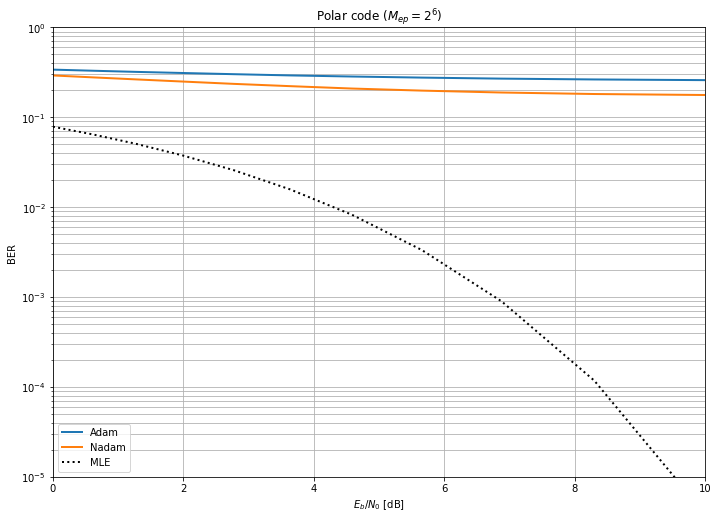

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
Total params: 12,776
Trainable params: 12,776
Non-trainable params: 0
_________________________________________________

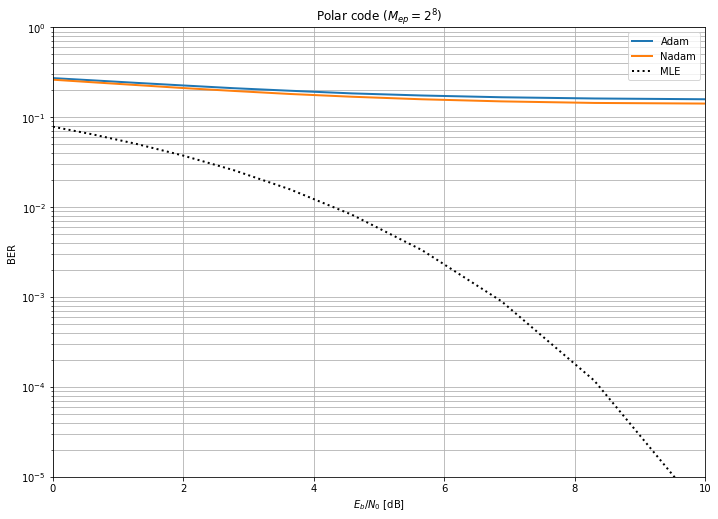

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 264       
Total params: 12,776
Trainable params: 12,776
Non-trainable params: 0
_________________________________________________

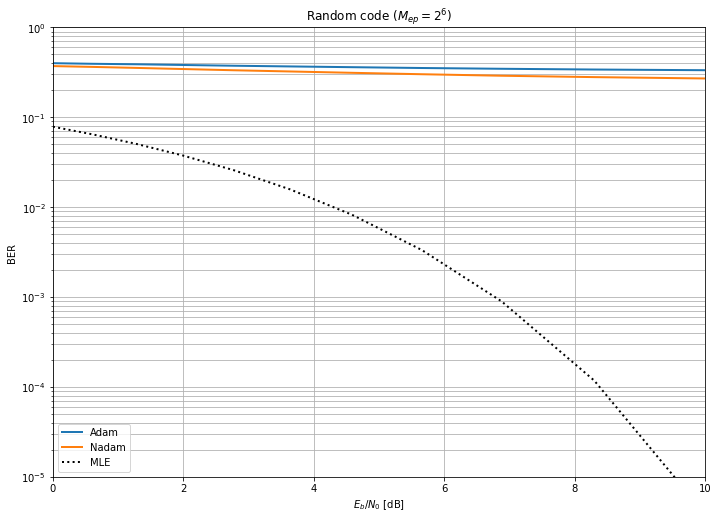

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 16)                0         
_________________________________________________________________
noise (Lambda)               (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 264       
Total params: 12,776
Trainable params: 12,776
Non-trainable params: 0
_________________________________________________

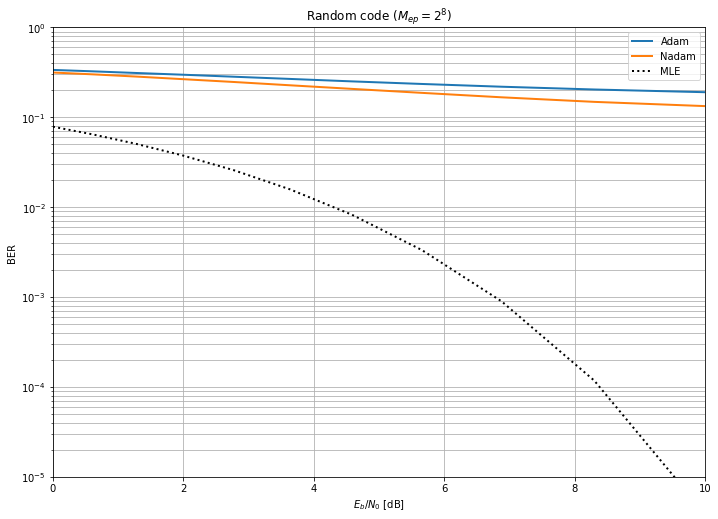

In [8]:
dump = {}

dump['sys'] = {}
dump['meta'] = {}
dump['exec'] = {}

for code in codes:
    
    dump['exec'][code] = {}
    
    # Create all possible information words
    d = np.zeros((2**k,k),dtype=bool)
    for i in range(1,2**k):
        d[i]= inc_bool(d[i-1])

    # Create sets of all possible codewords (codebook)
    if code == 'polar':   

        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d

        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)

    for nb_epoch in nb_epochs:
        
        nb_epoch_exp = int(np.log2(nb_epoch))
        
        dump['exec'][code][nb_epoch] = {}
        
        # https://stackoverflow.com/questions/15571267/python-a4-size-for-a-plot
        fig = plt.figure(figsize=(11.69,8.27))

        for optimizer in optimizers:
            
            dump['exec'][code][nb_epoch][optimizer] = {}

            ###################
            # Define NN model #
            ###################

            # Define modulator
            modulator_layers = [Lambda(modulateBPSK, 
                                      input_shape=(N,), output_shape=return_output_shape, name="modulator")]
            modulator = compose_model(modulator_layers)
            modulator.compile(optimizer=optimizer, loss=loss)

            # Define noise
            noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                                   input_shape=(N,), output_shape=return_output_shape, name="noise")]
            noise = compose_model(noise_layers)
            noise.compile(optimizer=optimizer, loss=loss)

            # Define LLR
            llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                                 input_shape=(N,), output_shape=return_output_shape, name="LLR")]
            llr = compose_model(llr_layers)
            llr.compile(optimizer=optimizer, loss=loss)

            # Define decoder 
            decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
            for i in range(1,len(design)):
                decoder_layers.append(Dense(design[i], activation='relu'))
            decoder_layers.append(Dense(k, activation='sigmoid'))
            decoder = compose_model(decoder_layers)
            decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

            # Define model
            if LLR:
                model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
            else:
                model_layers = modulator_layers + noise_layers + decoder_layers
            model = compose_model(model_layers)
            model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

            ############
            # Train NN #
            ############    

            model.summary()

            start_time = timeit.default_timer()
            print(f'{datetime.now()}\t{code} @ {optimizer} @ Mep=2^{nb_epoch_exp} fit started.')
            history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)
            end_time = timeit.default_timer()
            print(f'{datetime.now()}\t{code} @ {optimizer} @ Mep=2^{nb_epoch_exp} fit finished (took {end_time-start_time:1.3f} [s]).')

            ###########
            # Test NN #
            ###########

            test_batch = 100  
            num_words = 10000      # multiple of test_batch

            SNR_dB_start_Eb = 0
            SNR_dB_stop_Eb = 10
            SNR_points = SNR_dB_stop_Eb - SNR_dB_start_Eb + 1

            SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
            SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

            sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
            sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

            sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)
            sigmas_db = 10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N)
            print(f'{datetime.now()}\ttest @ sigmas={sigmas}')
            print(f'{datetime.now()}\ttest @ sigmas(dB)={sigmas_db}')

            nb_errors = np.zeros(len(sigmas),dtype=int)
            nb_bits = np.zeros(len(sigmas),dtype=int)

            for i in range(0,len(sigmas)):
                
                np.random.seed(0)

                for ii in range(0,np.round(num_words/test_batch).astype(int)):

                    # Source
                    d_test = np.random.randint(0,2,size=(test_batch,k)) 

                    # Encoder
                    if code == 'polar':
                        x_test = np.zeros((test_batch, N),dtype=bool)
                        u_test = np.zeros((test_batch, N),dtype=bool)
                        u_test[:,A] = d_test

                        for iii in range(0,test_batch):
                            x_test[iii] = polar_transform_iter(u_test[iii])

                    elif code == 'random':
                        x_test = np.zeros((test_batch, N),dtype=bool)
                        for iii in range(0,test_batch):
                            x_test[iii] = x[bin2int(d_test[iii])]

                    # Modulator (BPSK)
                    s_test = -2*x_test + 1

                    # Channel (AWGN)
                    y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

                    if LLR:
                        y_test = 2*y_test/(sigmas[i]**2)

                    # Decoder
                    nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
                    nb_bits[i] += d_test.size

                print(f'{datetime.now()}\ttest @ sigma[{i}]={sigmas[i]:.3f}\tsigma_db[{i}]={sigmas_db[i]:.3f}\tnb_bits={nb_bits[i]}\tnb_errors={nb_errors[i]}')

            #######################
            # Plot Bit-Error-Rate #
            #######################

            # NN decoder
            x_nn = sigmas_db
            y_nn = nb_errors/nb_bits
            plt.semilogy(x_nn, y_nn, label=optimizer.capitalize(), linestyle='solid', linewidth=2.0)

            ###################################
            # Persist current results to JSON #
            ###################################

            dump['exec'][code][nb_epoch][optimizer]['x_nn'] = x_nn.tolist()
            dump['exec'][code][nb_epoch][optimizer]['y_nn'] = y_nn.tolist()
        
        ############
        # Figure 3 #
        ############
        
        # MLE decoder
        x_mle = sigmas_db
        y_mle = [theoretic_symbol_error_rate(Es_No_dB) for Es_No_dB in sigmas_db]
        dump['exec'][code][nb_epoch][optimizer]['x_mle'] = x_mle.tolist()
        dump['exec'][code][nb_epoch][optimizer]['y_mle'] = y_mle
        plt.semilogy(x_mle, y_mle, label='MLE', linestyle='dotted', linewidth=2.0, color='black')
        
        plt.grid(True, which="both")
        plt.legend()
        plt.xlabel('$E_b/N_0$ [dB]')
        plt.ylabel('BER')
        plt.xlim(SNR_dB_start_Eb, SNR_dB_stop_Eb)
        plt.ylim(1e-5, 1e0)
        plt.title(code.capitalize() + ' code ($M_{ep}=2^{' + str(nb_epoch_exp) + '})$')
        plt.savefig(f'code={code}_epochs=2^{nb_epoch_exp}.png')
        plt.show()
        
        ################################
        # Persist current plot to JSON #
        ################################
        
        with open(f'code={code}_epochs=2^{nb_epoch_exp}.png', 'rb') as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
        dump['exec'][code][nb_epoch]['plot_base64'] = encoded_string

In [9]:
############################
# Persist metadata to JSON #
############################
            
dump['sys']['v_info'] = sys.version_info
dump['sys']['v_numpy'] = np.__version__
dump['sys']['v_keras'] = k_tmp.__version__
dump['sys']['v_tensorflow'] = tf_tmp.__version__
dump['sys']['is_gpu_available'] = tf.test.is_gpu_available(cuda_only=True)
dump['sys']['local_devices'] = str(device_lib.list_local_devices())
dump['sys']['keras_backend'] = K.backend()
dump['sys']['datetime'] = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')

dump['meta']['k'] = k
dump['meta']['N'] = N
dump['meta']['train_SNR_Eb'] = train_SNR_Eb
dump['meta']['nb_epochs'] = nb_epochs
dump['meta']['codes'] = codes
dump['meta']['design'] = design
dump['meta']['batch_size'] = batch_size
dump['meta']['LLR'] = LLR
dump['meta']['loss'] = loss
dump['meta']['optimizers'] = optimizers
dump['meta']['train_SNR_Es'] = train_SNR_Es
dump['meta']['train_sigma'] = train_sigma
dump['meta']['test_batch'] = test_batch
dump['meta']['num_words'] = num_words
dump['meta']['SNR_dB_start_Eb'] = SNR_dB_start_Eb
dump['meta']['SNR_dB_stop_Eb'] = SNR_dB_stop_Eb
dump['meta']['SNR_points'] = SNR_points
dump['meta']['sigmas'] = sigmas.tolist()
dump['meta']['sigmas_db'] = sigmas_db.tolist()

In [10]:
##############################
# Persist JSON to filesystem #
##############################

with open(f'code={code}.json', 'w') as outfile: 
    json.dump(dump, outfile)